In [1]:
from utils import matplotlib_style
import numpy as np
import math
import scipy
from scipy.integrate import quad
from scipy.special import gammaln, logsumexp
import mpmath
import matplotlib.pyplot as plt
import seaborn as sns

cor, pal = matplotlib_style()

# Set random seed
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

## Confluent Hypergeometric Function of the First Kind (Kummer's Function)

In this notebook, we will explore different numerical approaches to computing
the so-called Kummer's function, which is a solution to the Kummer differential
equation
$$
z \frac{d^2 w}{dz^2} + (b - z) \frac{dw}{dz} - a w = 0.
\tag{1}
$$
The Kummer's function is defined as
$$
{}_1F_1(a, b, z) = \sum_{n=0}^{\infty} \frac{(a)_n}{(b)_n} \frac{z^n}{n!},
\tag{2}
$$
where $(a)_n$ is the Pochhammer symbol, also known as the rising factorial,
defined as
$$
(a)_n = a(a+1)(a+2)\cdots(a+n-1).
\tag{3}
$$
The challenging part of computing the Kummer's function is that the series
converges slowly, and the terms grow rapidly. This makes it difficult to
evaluate the series directly.

There are different functions within the `Python` ecosystem that can be used to
to evaluate Kummer's function. `Scipy` provides the `scipy.special.hyp1f1`, but
this function is not very efficient for large values of `z`. `mpmath` provides
a high-precision implementation of the Kummer's function, but it is 
computationally expensive and inefficient at certain parameter regimes. However,
it is the "gold standard" for evaluating the Kummer's function.

## `mpmath` high-precision implementation

Let's begin then defining the Kummer's function using the `mpmath` library. We
will use the `numpy` `frompyfunc` to be able to evaluate the Kummer's function
for arrays of values. Everything we test afterwards will be compared to this
implementation.

In [2]:
# define a np.frompyfunc that allows us to evaluate the sympy.mp.math.hyp1f1
np_log_hyp = np.frompyfunc(
    lambda x, y, z: mpmath.ln(mpmath.hyp1f1(x, y, z, zeroprec=1024)), 3, 1
)

## Large $a$ and $b$ regime

The most challenging regime we have to deal with is when $a$ and $b$ are large.
This is essential for the computations we want to make with the Kummer's
function.

The [*Digital Library of Mathematical Functions*
(DLMF)](https://dlmf.nist.gov/13.8) provides an asymptotic approximation for the
Kummer's function when $a$ and $b$ are large. The asymptotic approximation is
of the form
$$
M(a, b, z) = \mathrm{e}^{\nu z} 
\frac{\Gamma^*(b)}{\Gamma^*(a)}
\left(
    1+\frac{(1-\nu)\left(1+6 v^2 z^2\right)}{12 a}+
    \mathcal{O}\left(\frac{1}{\min \left(a^2, b^2\right)}\right)
\right),
\tag{4}
$$
where $\nu = a / b$ and $\Gamma^*(z)$ is the [scaled gamma
function](https://dlmf.nist.gov/5.11#E3) defined as
$$
\Gamma^*(z) \sim 
\mathrm{e}^{-z} 
z^z\left(\frac{2 \pi}{z}\right)^{1 / 2} 
\sum_{k=0}^{\infty} \frac{g_k}{z^k},
\tag{5}
$$
with
$$
\begin{aligned}
& g_0=1, \\
& g_1=\frac{1}{12}, \\
& g_2=\frac{1}{288}, \\
& g_3=-\frac{139}{51840}, \\
& g_4=-\frac{571}{2488320}, \\
& g_5=\frac{163879}{209018880}, \\
& g_6=\frac{5246819}{75246796800} . \\
\end{aligned}
\tag{6}
$$
and in general,
$$
g_k=\sqrt{2}\left(\frac{1}{2}\right)_k a_{2 k},
\tag{7}
$$
where
$$
a_0 = \frac{1}{2}\sqrt{2},
\tag{8}
$$
and
$$
a_0 a_k + 
\frac{1}{2} a_1 a_{k-1}+\frac{1}{3} a_2 a_{k-2} + \cdots + 
\frac{1}{k+1} a_k a_0 = \frac{1}{k} a_{k-1}.
\tag{9}
$$

The DLMF cites [this paper](https://www.jstor.org/stable/2004538?casa_token=OhPd95uSK-YAAAAA:hRDdWnyk2IperpmCPyY_Cy-pPNozclcx0Q_DTtFU1l8jkPsyj6US2fjpLvuLp-hkeDkhPJk6i_9c5m2-2Mz_dxWatJP_06YaSIbdeOQ5O8Em9jsGdWXg) listing the first 20 values of $g_k$. The list is the 
following:
$$
\begin{aligned}
& g_0 = 1 \\
& g_1 = \frac{1}{12} \\
& g_2 = \frac{1}{288} \\
& g_3 = - \frac{139}{51840} \\
& g_4 = - \frac{571}{2488320} \\
& g_5 = \frac{163,879}{209,018,880} \\
& g_6 = \frac{5,246,819}{75,246,796,800} \\
& g_7 = - \frac{534,703,531}{902,961,561,600} \\
& g_8 = - \frac{4,483,131,259}{86,684,309,913,600} \\
& g_9 = \frac{432,261,921,612,371}{514,904,800,886,784,000} \\
& g_{10} = \frac{6,232,523,202,521,089}{86,504,006,548,979,712,000} \\
& g_{11} = - \frac{25,834,629,665,134,204,969}{13,494,625,021,640,835,072,000} \\
& g_{12} = - \frac{1,579,029,138,854,919,086,429}{9,716,130,015,581,401,251,840,000} \\
& g_{13} = \frac{746,590,869,962,651,602,203,151}{116,593,560,186,976,815,022,080,000} \\
& g_{14} = \frac{1,511,513,601,028,097,903,631,961}{2,798,245,444,487,443,560,529,920,000} \\
& g_{15} = - \frac{8,849,272,268,392,873,147,705,987,190,261}{299,692,087,104,605,205,332,754,432,000,000} \\
& g_{16} = - \frac{142,801,712,490,607,530,608,130,701,097,701}{57,540,880,724,084,199,423,888,850,944,000,000} \\
& g_{17} = \frac{2,355,444,393,109,967,510,921,431,436,000,087,153}{13,119,320,805,091,197,468,646,658,015,232,000,000} \\
& g_{18} = \frac{2,346,608,607,351,903,737,647,919,577,082,115,121,863}{155,857,531,164,483,425,927,522,297,220,956,160,000,000} \\
& g_{19} = - \frac{2,603,072,187,220,373,277,150,999,431,416,562,396,331,667}{1,870,290,373,973,801,111,130,267,566,651,473,920,000,000} \\
& g_{20} = - \frac{73,239,727,426,811,935,976,967,471,475,430,268,695,630,993}{628,417,565,655,197,173,339,769,902,394,895,237,120,000,000} \\
&
\end{aligned}
\tag{10}
$$

Let's pack the elements of this list into a `Python` dictionary.

In [3]:
g_k_dict = {
    "g_0": 1,
    "g_1": 1/12,
    "g_2": 1/288,
    "g_3": - 139/51840,
    "g_4": - 571/2488320,
    "g_5": 163879/209018880,
    "g_6": 5246819/75246796800,
    "g_7": - 534703531/902961561600,
    "g_8": - 4483131259/86684309913600,
    "g_9": 432261921612371/514904800886784000,
    "g_10": 6232523202521089/86504006548979712000,
    "g_11": - 25834629665134204969/13494625021640835072000,
    "g_12": - 1579029138854919086429/9716130015581401251840000,
    "g_13": 746590869962651602203151/116593560186976815022080000,
    "g_14": 1511513601028097903631961/2798245444487443560529920000,
    "g_15": - 8849272268392873147705987190261/299692087104605205332754432000000,
    "g_16": - 142801712490607530608130701097701/57540880724084199423888850944000000,
    "g_17": 2355444393109967510921431436000087153/13119320805091197468646658015232000000,
    "g_18": 2346608607351903737647919577082115121863/155857531164483425927522297220956160000000,
    "g_19": - 2603072187220373277150999431416562396331667/1870290373973801111130267566651473920000000,
    "g_20": - 73239727426811935976967471475430268695630993/628417565655197173339769902394895237120000000
}

Next, let's implement the asymptotic approximation for the Kummer's function.

In [4]:
def scaled_gamma_function(z, n_terms, coefficients):
    """
    Computes the scaled gamma function Γ*(z) up to a specified number of terms.

    The scaled gamma function is given by:
    Γ*(z) ∼ e^(-z) * z^z * (2π/z)^(1/2) * Σ (g_k / z^k), for k=0 to ∞

    Parameters
    ----------
    - z (float or complex): The argument of the scaled gamma function.
    - n_terms (int): The number of terms to include in the series approximation.
    - coefficients (dict): A dictionary containing the coefficients g_k.

    Returns
    -------
    - float or complex: The computed value of the scaled gamma function Γ*(z).
    """
    # Compute the prefactor e^(-z) * z^z * (2π/z)^(1/2)
    prefactor = np.exp(-z) * (z ** z) * ((2 * np.pi / z) ** 0.5)

    # Compute the series sum Σ (g_k / z^k) for k=0 to n_terms-1
    series_sum = sum(coefficients[f"g_{k}"] / (z ** k) for k in range(n_terms))

    # Compute the scaled gamma function Γ*(z)
    gamma_star = prefactor * series_sum

    return gamma_star

We will also need the log of the gamma function.

In [5]:
def log_scaled_gamma_function(z, n_terms, coefficients):
    """
    Computes the logarithm of the scaled gamma function log(Γ*(z)) up to a
    specified number of terms.

    The scaled gamma function is given by: 
    Γ*(z) ∼ e^(-z) * z^z * (2π/z)^(1/2) * Σ (g_k / z^k), for k=0 to ∞

    Parameters
    ----------
    - z (float or complex): The argument of the scaled gamma function.
    - n_terms (int): The number of terms to include in the series approximation.
    - coefficients (dict): A dictionary containing the coefficients g_k.

    Returns
    -------
    - float or complex: The computed value of the logarithm of the scaled gamma
      function log(Γ*(z)).
    """
    # Compute the logarithm of the prefactor log(e^(-z) * z^z * (2π/z)^(1/2))
    log_prefactor = -z + z * np.log(z) + 0.5 * np.log(2 * np.pi / z)

    # Compute the series sum Σ (g_k / z^k) for k=0 to n_terms-1
    series_sum = sum(coefficients[f"g_{k}"] / (z ** k) for k in range(n_terms))

    # Compute the logarithm of the series sum
    log_series_sum = np.log(series_sum)

    # Compute the logarithm of the scaled gamma function log(Γ*(z))
    log_gamma_star = log_prefactor + log_series_sum

    return log_gamma_star

Now we can implement the asymptotic approximation for the Kummer's function.

In [6]:
def large_a_b_kummer(a, b, z, n_terms, coefficients):
    """
    Computes an approximation of the confluent hypergeometric function 1F1(a, b,
    z) for large values of the parameters a and b using the function M(a, b, z)
    as described in the provided formula.

    The function M(a, b, z) is given by:
    M(a, b, z) = e^(νz) * (Γ*(b) / Γ*(a)) * 
                 (1 + ((1-ν) * (1 + 6ν^2z^2)) / (12a) + O(1/min(a^2, b^2)))

    Parameters
    ----------
    - a (float): The parameter 'a' in the function.
    - b (float): The parameter 'b' in the function.
    - z (float or complex): The argument 'z' in the function.
    - n_terms (int): The number of terms to include in the series approximation
      for the scaled gamma functions.
    - coefficients (dict): A dictionary containing the coefficients g_k for the
      scaled gamma functions.

    Returns
    -------
    - float or complex: The computed value of the function M(a, b, z).
    """
    # Define the parameter ν = a / b
    nu = a / b

    # Compute the exponential term e^(νz)
    exp_term = np.exp(nu * z)

    # Compute the logarithms of the scaled gamma functions log(Γ*(b)) and
    # log(Γ*(a))
    log_gamma_star_b = log_scaled_gamma_function(b, n_terms, coefficients)
    log_gamma_star_a = log_scaled_gamma_function(a, n_terms, coefficients)

    # Compute the ratio Γ*(b) / Γ*(a)
    gamma_ratio = np.exp(log_gamma_star_b - log_gamma_star_a)

    # Compute the correction term (1 + ((1-ν) * (1 + 6ν^2z^2)) / (12a))
    correction_term = 1 + ((1 - nu) * (1 + 6 * nu**2 * z**2)) / (12 * a)

    # Compute the function M(a, b, z)
    M_value = exp_term * gamma_ratio * correction_term

    return M_value

Likewise, we can implement the log of this asymptotic approximation for the
Kummer's function.

In [7]:
def log_large_a_b_kummer(a, b, z, n_terms=20, coefficients=g_k_dict):
    """
    Computes the logarithm of the Kummer function M(a, b, z) for large values of
    the parameters a and b using the function M(a, b, z) as

    M(a, b, z) = e^(νz) * (Γ*(b) / Γ*(a)) * 
                 (1 + ((1-ν) * (1 + 6ν^2z^2)) / (12a) + O(1/min(a^2, b^2)))

    Parameters
    ----------
    - a (float): The parameter 'a' in the function.
    - b (float): The parameter 'b' in the function.
    - z (float or complex): The argument 'z' in the function.
    - n_terms (int): The number of terms to include in the series approximation
      for the scaled gamma functions.
    - coefficients (dict): A dictionary containing the coefficients g_k for the
      scaled gamma functions.

    Returns
    -------
    - float or complex: The computed value of the logarithm of the function M(a,
      b, z).
    """
    # Define the parameter ν = a / b
    nu = a / b

    # Compute the logarithm of the exponential term log(e^(νz)) = νz
    log_exp_term = nu * z

    # Compute the logarithms of the scaled gamma functions log(Γ*(b)) and
    # log(Γ*(a))
    log_gamma_star_b = log_scaled_gamma_function(b, n_terms, coefficients)
    log_gamma_star_a = log_scaled_gamma_function(a, n_terms, coefficients)

    # Compute the logarithm of the ratio Γ*(b) / Γ*(a)
    log_gamma_ratio = log_gamma_star_b - log_gamma_star_a

    # Compute the correction term (1 + ((1-ν) * (1 + 6ν^2z^2)) / (12a))
    correction_term = 1 + ((1 - nu) * (1 + 6 * nu**2 * z**2)) / (12 * a)

    # Compute the logarithm of the correction term
    log_correction_term = np.log(correction_term)

    # Compute the logarithm of the function M(a, b, z)
    log_M_value = log_exp_term + log_gamma_ratio + log_correction_term

    return log_M_value

Let's test this function for the correct parameter regime.

In [8]:
# Define parameters
a = 1002
b = 1005
z = -100

# Compute the Kummer function M(a, b, z) using the large_a_b_kummer function
approx_M = log_large_a_b_kummer(a, b, z, n_terms=20, coefficients=g_k_dict)

approx_M

-78.9545426872107

## Two-state promoter log probability

The reason we are interested in the Kummer's function is that it appears in the
steady-state mRNA distribution of a two-state promoter model. This distribution
is of the form
$$
{\scriptstyle
P(m) = 
\frac{1}{\Gamma(m + 1)}
\frac{
    \Gamma
    \left(
        \frac{k^{(p)}_{\text{on}}}{\gamma_m} + m
    \right)
}{
    \Gamma
    \left(
        \frac{k^{(p)}_{\text{on}}}{\gamma_m}
    \right)
}
\frac{
    \Gamma
    \left(
        \frac{k^{(p)}_{\text{on}} + k^{(p)}_{\text{off}}}{\gamma_m}
    \right)
}{
    \Gamma
    \left(
        \frac{k^{(p)}_{\text{on}} + k^{(p)}_{\text{off}}}{\gamma_m} + m 
    \right)
}
\left( \frac{r_m}{\gamma_m} \right)^m \\
\times {}_1F_1 
\left(
    \frac{
            k^{(p)}_{\text{on}} 
        }{
            \gamma_m
        }
    + m,
    \frac{
            k^{(p)}_{\text{on}} + k^{(p)}_{\text{off}} 
        }{
            \gamma_m
        }
    + m,
    - \frac{r_m}{\gamma_m}
\right),
}
\tag{11}
$$


where $m$ is the steady-state mRNA copy number per cell, $k_on^{(p)}$ and
$k_off^{(p)}$ are the rate constants for the promoter turning on and off,
respectively, $r_m$ is the mRNA production rate, and $\gamma_m$ is the mRNA
degradation rate.

Since the $a$ and $b$ terms in the Kummer's function grow with the number of
mRNAs, we need to be able to evaluate the Kummer's function for large values of
these parameters.

Let's define a function that computes the log of the probability distribution in
Eq. (11). For this function, we will have the function to evaluate the Kummer's
function as an argument.

In [9]:
def log_p_m(mRNA, kp_on, kp_off, rm, gm=1, log_M_func=np_log_hyp):
    '''
    Computes the log probability lnP(m) for a two-state promoter model, i.e. the
    probability of having m mRNA.

    Parameters
    ----------
    mRNA : float.
        mRNA copy number at which evaluate the probability.
    kp_on : float.
        rate of activation of the promoter in the chemical master equation
    kp_off : float.
        rate of deactivation of the promoter in the chemical master equation
    rm : float.
        production rate of the mRNA
    gm : float.
        1 / half-life time for the mRNA.
    log_M_func : function.
        Function to evaluate the log Kummer function.

    Returns
    -------
    log probability lnP(m)
    '''
    # Convert the mRNA copy number to a  numpy array
    mRNA = np.array(mRNA)

    # Compute the probability
    lnp = scipy.special.gammaln(kp_on / gm + mRNA) \
        - scipy.special.gammaln(mRNA + 1) \
        - scipy.special.gammaln((kp_off + kp_on) / gm + mRNA) \
        + scipy.special.gammaln((kp_off + kp_on) / gm) \
        - scipy.special.gammaln(kp_on / gm) \
        + mRNA * np.log(rm / gm) \
        + log_M_func(
            kp_on / gm + mRNA,
            (kp_off + kp_on) / gm + mRNA,
            -rm / gm
    )

    return lnp

This function evaluates the log probability for a single mRNA copy number. 
Usually, we need to compute this log probability for a range of copy numbers. 
But as $m$ increases, the high precision of the `mpmath` library fails to 
converge to the correct value. Therefore, we need to define a function that 
evaluates this log probability for a range of mRNA copy numbers, but once the
first failure in the high-precision computation is detected, it automatically
switches to the asymptotic approximation.

In [10]:
def log_probability(
    mRNA_values,
    kp_on,
    kp_off,
    rm,
    log_M_func=np_log_hyp,
    log_M_approx=log_large_a_b_kummer,
    gm=1,
):
    """
    Evaluates the log probability for a range of mRNA values.

    Parameters
    ----------
    - mRNA_values (array-like): The range of mRNA values to evaluate.
    - kp_on (float): Rate of activation of the promoter.
    - kp_off (float): Rate of deactivation of the promoter.
    - rm (float): Production rate of the mRNA.
    - gm (float): 1 / half-life time for the mRNA.
    - n_terms (int): The number of terms to include in the series approximation
      for the scaled gamma functions.
    - coefficients (dict): A dictionary containing the coefficients g_k for the
      scaled gamma functions.
    - M_func (function): The default function to compute M(a, b, z).
    - log_large_a_b_kummer (function): The fallback function to compute the log
      of M(a, b, z).

    Returns
    -------
    - list: The computed log probabilities for the range of mRNA values.
    """
    log_probs = []
    use_large_a_b = False

    for mRNA in mRNA_values:
        if use_large_a_b:
            # Use log_large_a_b_kummer for the rest of the evaluations
            log_prob = log_p_m(
                mRNA, kp_on, kp_off, rm, gm, log_M_approx
            )
        else:
            try:
                # Compute the log probability using the default M_func
                log_prob = float(
                    log_p_m(mRNA, kp_on, kp_off, rm, gm, log_M_func)
                )

                # Check if the result is infinity or NaN
                if np.isinf(log_prob) or np.isnan(log_prob):
                    raise ValueError("Result is infinity or NaN")

            except:
                # Switch to using log_large_a_b_kummer if M_func fails
                log_prob = log_p_m(
                    mRNA, kp_on, kp_off, rm, gm, log_M_approx
                )
                use_large_a_b = True

        log_probs.append(log_prob)

    return log_probs

Let's make sure that the function is working by evaluating it at a parameter
regime we know works with the high-precision `mpmath` library.

Text(0, 0.5, 'Probability')

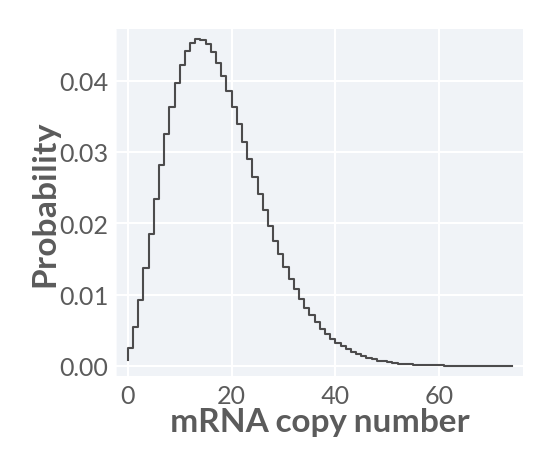

In [11]:
# Define parameters
k_on = 4.0
k_off = 18.0
r_m = 100.0

# Define range of mRNA
m_range = np.arange(0, 75)

# Evaluate the log probability
logP = log_probability(m_range, k_on, k_off, r_m)

# Initialize figure
fig, ax = plt.subplots(1, 1, figsize=(1.75, 1.5))

# Plot the probability
ax.step(m_range, np.exp(logP))

# Label axis
ax.set_xlabel("mRNA copy number")
ax.set_ylabel("Probability")

This is the expected form of the probability distribution. Let's now test the
function for a parameter regime where the high-precision `mpmath` library fails.

Text(0, 0.5, 'Probability')

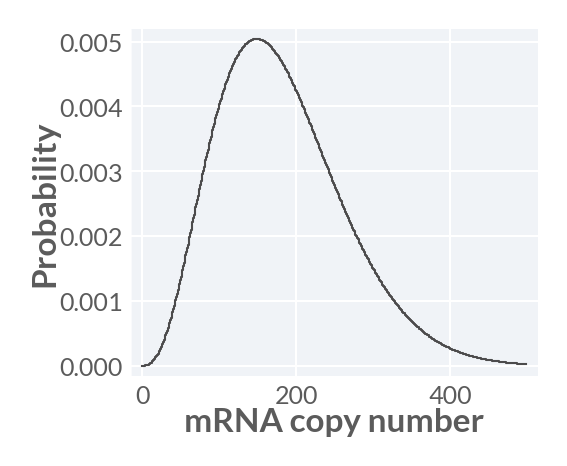

In [12]:
# Define parameters
k_on = 4.0
k_off = 18.0
r_m = 1000.0

# Define range of mRNA
m_range = np.arange(0, 500)

# Evaluate the log probability
logP = log_probability(m_range, k_on, k_off, r_m)

# Initialize figure
fig, ax = plt.subplots(1, 1, figsize=(1.75, 1.5))

# Plot the probability
ax.step(m_range, np.exp(logP))

# Label axis
ax.set_xlabel("mRNA copy number")
ax.set_ylabel("Probability")

This looks excellent! The asymptotic approximation seems to be working really
well. Let's try an even more challenging parameter regime.

Text(0, 0.5, 'Probability')

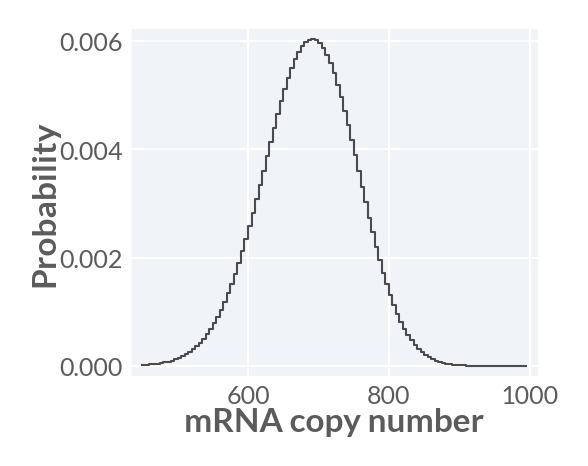

In [13]:
# Define parameters
k_on = 40.0
k_off = 18.0
r_m = 1000.0

# Define range of mRNA
m_range = np.arange(450, 1000, 5)

# Evaluate the log probability
logP = log_probability(m_range, k_on, k_off, r_m)

# Initialize figure
fig, ax = plt.subplots(1, 1, figsize=(1.75, 1.5))

# Plot the probability
ax.step(m_range, np.exp(logP))

# Label axis
ax.set_xlabel("mRNA copy number")
ax.set_ylabel("Probability")

Another excellent result! The asymptotic approximation seems to be working
really well. 

## Integral form of the Kummer's function

The Kummer's function can also be written in the integral form

$$
M(a, b, z) = \frac{\Gamma(b)}{\Gamma(a) \Gamma(b-a)} 
\int_0^1 dt \; e^{z t} t^{a-1}(1-t)^{b-a-1},
\tag{12}
$$
where $b > 0$ and $(b - a) > 0$. This integral form could be computationally
difficult to evaluate for large positive values of $z$ because of the
exponential growth of the integrand. However, for our particular case, $z < 0$,
making it easier to evaluate.

Let's define a function that computes this integral form of the Kummer's
function.

In [14]:
def log_kummer_integral(a, b, z, epsabs=1.49e-8, epsrel=1.49e-8, limit=50):
    """
    Computes the logarithm of the Kummer function M(a, b, z) using an integral
    representation with improved precision and robustness.
    
    Parameters:
    -----------
    a, b, z : float or complex
        Parameters of the Kummer function.
    epsabs, epsrel : float
        Absolute and relative error tolerances for the integration.
    limit : int
        Maximum number of subintervals used for the integration.
    
    Returns:
    --------
    float or complex
        The logarithm of the Kummer function M(a, b, z).
    """
    if b <= 0 or (b - a) <= 0:
        raise ValueError("Conditions b > 0 and (b - a) > 0 must be satisfied.")
    
    def log_integrand(t):
        return z * t + (a - 1) * np.log(t) + (b - a - 1) * np.log1p(-t)
    
    def integrand(t):
        return np.exp(log_integrand(t))
    
    # Use log-space integration for large absolute values of parameters
    use_log_space = np.abs(z) > 100 or np.abs(a) > 100 or np.abs(b) > 100
    
    if use_log_space:
        integral, error = quad(integrand, 0, 1,
                               epsabs=epsabs, epsrel=epsrel, limit=limit)
        log_integral = np.log(integral)
    else:
        integral, error = quad(integrand, 0, 1,
                               epsabs=epsabs, epsrel=epsrel, limit=limit)
        log_integral = np.log(integral)
    
    log_prefactor = gammaln(b) - (gammaln(a) + gammaln(b - a))
    
    return log_prefactor + log_integral

In [15]:
def log_kummer_integral(a, b, z):
    """
    Computes the logarithm of the Kummer function M(a, b, z) using an integral
    representation.

    This function calculates log(M(a, b, z)) where M is the Kummer function
    (confluent hypergeometric function of the first kind) using the integral
    representation:

    M(a, b, z) = [Γ(b) / (Γ(a) * Γ(b-a))] * 
                 ∫[0 to 1] e^(zt) * t^(b-a-1) * (1-t)^(a-1) dt

    The function computes this integral in log space to avoid numerical overflow
    for large parameter values.

    Parameters:
    -----------
    a : float
        The first parameter of the Kummer function.
    b : float
        The second parameter of the Kummer function. Must be greater than a.
    z : float or complex
        The argument of the Kummer function.

    Returns:
    --------
    float or complex
        The logarithm of the Kummer function M(a, b, z).

    Notes:
    ------
    - This method can be numerically stable for a wider range of parameters
      compared to direct computation.
    - The function uses scipy's quad for numerical integration and special
      functions for log-gamma calculations.
    - Care should be taken when b - a is not a positive integer, as the integral
      might not converge.
    """
    # Define the log of the integrand for the integral
    def log_integrand(t):
        log_term1 = z * t  # log(e^(zt)) = zt
        log_term2 = (a - 1) * np.log(t)
        log_term3 = (b - a - 1) * np.log(1 - t)
        return log_term1 + log_term2 + log_term3

    # Perform the integration over the interval [0, 1]
    integral, error = quad(lambda t: np.exp(log_integrand(t)), 0, 1)
    log_integral = np.log(integral)
    
    # Calculate the log of the prefactor: log(Gamma(b) / (Gamma(a) * Gamma(b-a)))
    log_prefactor = gammaln(b) - (gammaln(a) + gammaln(b - a))
    
    # Return the log of the result
    return log_prefactor + log_integral

Let's now compare the computation of the log probability using the integral form
of the Kummer's function to the log probability using the asymptotic
approximation.

Text(0, 0.5, 'Probability')

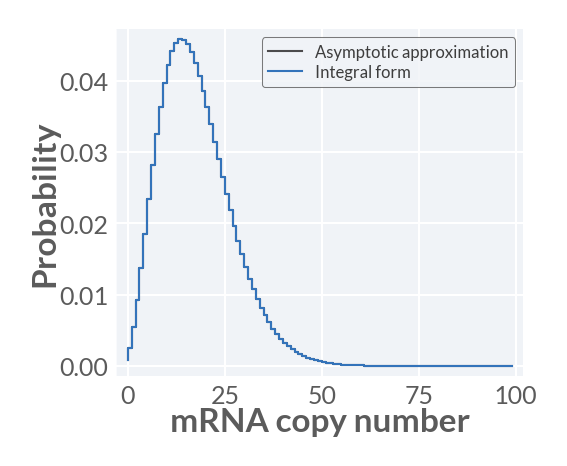

In [16]:
# Define parameters
k_on = 4.0
k_off = 18.0
r_m = 100.0

# Define range of mRNA
m_range = np.arange(0, 100)

# Evaluate the log probability
logP_asymp = log_probability(m_range, k_on, k_off, r_m)
logP_integral = log_probability(
    m_range, k_on, k_off, r_m, 
    log_M_func=log_kummer_integral, log_M_approx=log_kummer_integral
)

# Initialize figure
fig, ax = plt.subplots(1, 1, figsize=(1.75, 1.5))

# Plot the probability
ax.step(m_range, np.exp(logP_asymp), label="Asymptotic approximation")
ax.step(m_range, np.exp(logP_integral), label="Integral form")

# Add legend
ax.legend(fontsize="4")

# Label axis
ax.set_xlabel("mRNA copy number")
ax.set_ylabel("Probability")

For reasonable parameter regimes, the integral form of the Kummer's function
looks very similar to the high-precision approximation. However, as we let $r_m$
increase, there is a funny oscillatory behavior, as shown in the following
figure.

/var/folders/dn/1m77v71d7nsfd1x3hbgylp_80000gp/T/ipykernel_23981/444193076.py:48: RuntimeWarning: divide by zero encountered in log
  log_integral = np.log(integral)


Text(0, 0.5, 'Probability')

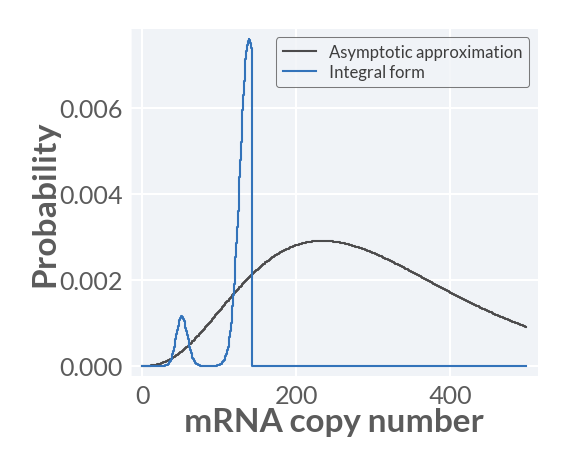

In [18]:
# Define parameters
k_on = 4.0
k_off = 100.0
r_m = 8000.0

# Define range of mRNA
m_range = np.arange(0, 500)

# Evaluate the log probability
logP_asymp = log_probability(m_range, k_on, k_off, r_m)
logP_integral = log_probability(
    m_range, k_on, k_off, r_m, 
    log_M_func=log_kummer_integral, log_M_approx=log_kummer_integral
)

# Initialize figure
fig, ax = plt.subplots(1, 1, figsize=(1.75, 1.5))

# Plot the probability
ax.step(m_range, np.exp(logP_asymp), label="Asymptotic approximation")
ax.step(m_range, np.exp(logP_integral), label="Integral form")

# Add legend
ax.legend(fontsize="4")

# Label axis
ax.set_xlabel("mRNA copy number")
ax.set_ylabel("Probability")

In [ ]:
# Define parameters
k_on = 4.0
k_off = 3.5
r_m = 2.5

# Define range of mRNA
m_range = np.arange(0, 90)

# Evaluate the log probability
logP_asymp = log_probability(
    m_range, k_on, k_off, r_m,
    log_M_approx=log_kummer_integral
)
logP_integral = log_probability(
    m_range, k_on, k_off, r_m, 
    log_M_func=log_kummer_integral, log_M_approx=log_kummer_integral
)

# Initialize figure
fig, ax = plt.subplots(1, 1, figsize=(1.75, 1.5))

# Plot the probability
ax.step(
    m_range, 
    np.exp(logP_asymp), 
    label="Asymptotic approximation"
)
ax.step(m_range, np.exp(logP_integral), label="Integral form")

# Add legend
ax.legend(fontsize="4")

# Label axis
ax.set_xlabel("mRNA copy number")
ax.set_ylabel("Probability")